<a href="https://colab.research.google.com/github/Lifeandcode404/Detective-Card-Fraud-Predictive-Model/blob/main/X%C3%A2y_d%E1%BB%B1ng_m%C3%B4_h%C3%ACnh_ph%C3%A1t_hi%E1%BB%87n_gian_l%E1%BA%ADn_th%E1%BA%BB_t%C3%ADn_d%E1%BB%A5ng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XÂY DỰNG MÔ HÌNH GIAN LẬN THẺ TÍN DỤNG**

<div style="text-align: center;">
  <img src="https://media.licdn.com/dms/image/C4D12AQE9UYEAdxvJOg/article-cover_image-shrink_600_2000/0/1632034924338?e=2147483647&v=beta&t=iIE0l0sJh4MfpuOefnpW--v_obcDlUajVkxvYLOabb4" width="500" alt="Giao dịch thẻ tín dụng" />
</div>



## **TỔNG QUAN VỀ BỘ DỮ LIỆU**
Bộ dữ liệu này chứa các giao dịch thẻ tín dụng được thực hiện vào **tháng 9 năm 2013** bởi chủ thẻ tại châu Âu. Dữ liệu ghi nhận các giao dịch xảy ra trong **hai ngày**, với **492 giao dịch gian lận trên tổng số 284.807 giao dịch**. **Đây là một bộ dữ liệu rất mất cân bằng, trong đó lớp dương (gian lận) chỉ chiếm 0,172% tổng số giao dịch.**

Bộ dữ liệu chỉ bao gồm các biến đầu vào dạng số, và các biến này là kết quả của phép biến đổi PCA (Principal Component Analysis) - Một kỹ thuật giảm chiều dữ liệu làm cho V1->V28 đã được chuẩn hóa và mang tính bảo mật cao.

*   Các đặc trưng V1, V2, …, V28 là các thành phần chính thu được sau khi áp dụng PCA.

*   Time: số giây đã trôi qua kể từ giao dịch đầu tiên trong bộ dữ liệu.
*   Amount: giá trị của giao dịch; đặc trưng này có thể được sử dụng trong các bài toán học nhạy chi phí (cost-sensitive learning) phụ thuộc vào từng mẫu.
*   Class là biến mục tiêu, nhận giá trị 1 nếu giao dịch là gian lận, và 0 nếu không phải gian lận.
* Nếu bắt sót ca gian lận thì tổn thất 100 USD, mà bắt nhầm khách hàng thì chi phí ít hơn.

## **1.** CÁC BƯỚC CHUẨN BỊ

**Liên kết với thư mục drive nơi để data**

In [1]:
from google.colab import drive
#Liên kết với drive để lấy file
drive.mount('/content/drive')

Mounted at /content/drive


**Import các thư viện cần thiết**

In [2]:
# --- 1. Core & Data Manipulation ---
import pandas as pd
import numpy as np
import joblib
from collections import Counter

# --- 2. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Preprocessing & Model Selection ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# --- 4. Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- 5. Imbalanced Learning (Sampling & Pipeline) ---
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# --- 6. Metrics & Evaluation ---
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

np.set_printoptions(precision=8, suppress=True)

**Tiến hành các bước đọc file và phân tích file**

In [11]:
#Đọc file
df = pd.read_csv('/content/drive/MyDrive/[Khoa]-Phát hiện gian lận thẻ tín dụng /creditcard.csv')

In [12]:
#in ra thông tin dữ liệu
print(">>>> Thông tin dữ liệu <<<<\n".upper())
df.info()

>>>> THÔNG TIN DỮ LIỆU <<<<

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-

In [13]:
print('>>>> Kích thước dữ liệu <<<<')
print(f"Data Card Credit Fraud có: {df.shape[0]} hàng, {df.shape[1]} cột.")

>>>> Kích thước dữ liệu <<<<
Data Card Credit Fraud có: 284807 hàng, 31 cột.


In [14]:
#in ra 5 dòng đầu
print(">>>> 5 dòng đầu tiên <<<<".upper())
df.head().round(2)

>>>> 5 DÒNG ĐẦU TIÊN <<<<


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.0,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.0,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.0,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.0,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [15]:
print(">>>> Kiểm tra giá trị thiếu trong dữ liệu <<<<".upper())
'''
1. Tìm và tính tổng dữ liệu null trong data
2. Tính tỉ lệ dữ liệu null trong data
'''
total_null = df.isnull().sum().sort_values(ascending = False)
percent_null = ( df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending = False)
pd.concat([total_null, percent_null], axis = 1, keys = ['Total', 'Percent']).transpose()

>>>> KIỂM TRA GIÁ TRỊ THIẾU TRONG DỮ LIỆU <<<<


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Từ đây ta có thể rút ra được dữ liệu hoàn toàn đầy đủ và không có Null, có thể tiếp tục xử lý.

In [16]:
#Kiểm tra thống kê mô tả
print('>>>> Thống kê mô tả <<<<'.upper())
df.describe().round(2)

>>>> THỐNG KÊ MÔ TẢ <<<<


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Từ các cột thống kê mô tả ta thấy được:
+ Dữ liệu có **284807 giao dịch** được xảy ra.
+ Dữ liệu của time được tính theo giây tổng có 172792 giây = 2 ngày
+ Giá trị 50% (median) là 84692.00, thấp hơn giá trị trung bình 94813.86, điều này cho thấy rằng phân phối có xu hướng hơi lệch về bên phải, nghĩa là có nhiều giao dịch xảy ra ở các mốc thời gian thấp hơn.

**Xem sơ bộ lớp Class để xem giao dịch bình thường và giao dịch gian lận**

In [17]:
#ta kiểm tra phân phối của hai mục tiêu cần xác địch là (Non-Fraud và Fraud)
fraud_count = df['Class'].value_counts()
total = len(df)
fraud_percent = (fraud_count / total) * 100

df_class = pd.DataFrame({
                          'Loại Giao Dịch': ['Bình thường (0)','Gian lận (1)'],
                          'Số lượng': fraud_count,
                          'Tỷ lệ (%)': fraud_percent.round(2)
                        })
df_class.set_index('Loại Giao Dịch', inplace = True)
df_class.transpose()

Loại Giao Dịch,Bình thường (0),Gian lận (1)
Số lượng,284315.00,492.00
Tỷ lệ (%),99.83,0.17


Từ đây ta rút ra được, trong 284807 giao dịch:
+ Có 284315 giao dịch bình thường -> chiếm tỷ lệ 99,83%
+ Có 492 giao dịch gian lận -> chiếm tỷ lệ 0,17%

 Xem xét được tỉ lệ giữa giao dịch bình thường và so với tổng thể thì có thể dữ liệu bị mất cân bằng nghiêm trọng. Do tỷ lệ giao dịch bình thường so với giao dịch gian lận bị lệch rất nhiều nếu chọn mô hình không chính xác có thể gây ra sai sót.

## **2.** PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU

**Vẽ biểu đồ xem sự tương quan giữa hai biến giao dịch là gian lận và không gian lận**

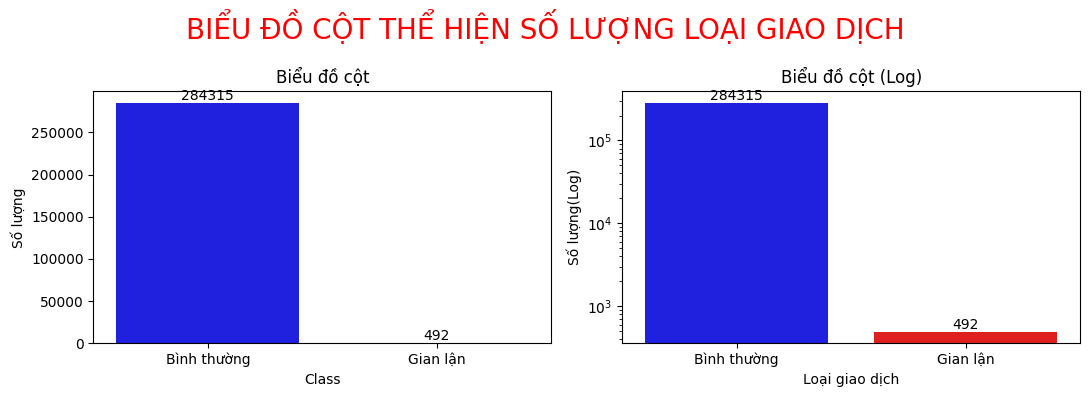

In [18]:
fig1 = plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
ax1 = sns.countplot(x='Class', data = df, palette = ['blue','red'], hue='Class', legend = False)
plt.title('Biểu đồ cột')
plt.xlabel('Class')
plt.ylabel('Số lượng')
plt.xticks([0,1],['Bình thường', 'Gian lận'])
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', fontsize=10)

plt.subplot(1,2,2)
ax2 = sns.countplot(x='Class', data = df, palette =  ['blue','red'], hue='Class', legend = False)
plt.title('Biểu đồ cột (Log)')
plt.xlabel('Loại giao dịch')
plt.ylabel('Số lượng(Log)')
plt.yscale('log')
plt.xticks([0,1],['Bình thường', 'Gian lận'])
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', fontsize=10)

fig1.suptitle("BIỂU ĐỒ CỘT THỂ HIỆN SỐ LƯỢNG LOẠI GIAO DỊCH", fontsize = 20, color = 'r')
plt.tight_layout()
plt.show()

Từ biểu đồ cột thể hiện số lượng loại giao dịch, ta rút ra được rằng là:
+ Sự chênh lệch "khổng lồ" về số lượng giữa giao dịch Bình thường và Gian lận.
+ Khi train mô hình thì cái tỷ lệ lệch như vậy sẽ ảnh hưởng tới các chỉ số đặc biệt là Accuracy sẽ rất cao nhưng thật ra là vì bị lệch. Phải dùng Recall, Precision, F1-Score hoặc AUC-ROC.
+ Bắt buộc phải xử lý dữ liệu (Resampling).



**Vẽ biểu đồ histogram và boxplot để thấy được phân phối của biến Amount.**
+ Phân tích biến Amount chính là phân tích số tiền bị trộm lấy đi và trả lời cho câu hỏi "các giao dịch gian lận thường trộm bao nhiêu tiền và (nhỏ hay lớn).

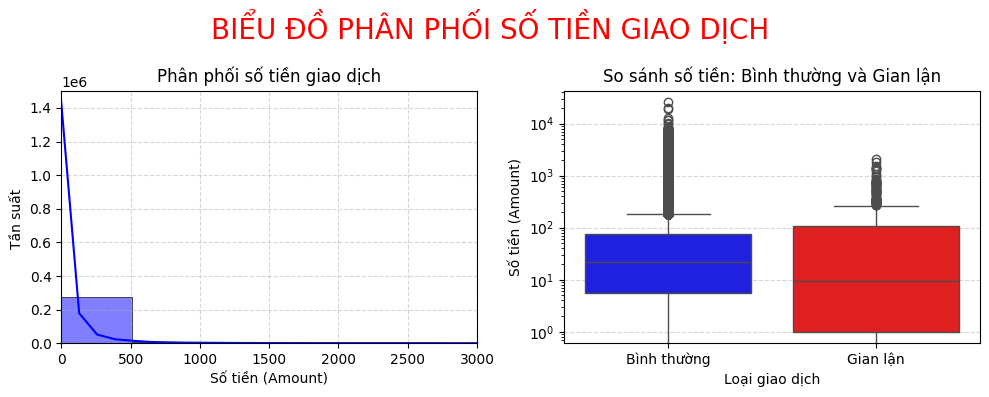

------------------------------------------------------------
SO SÁNH SỐ TIỀN GIAO DỊCH: BÌNH THƯỜNG VS GIAN LẬN


,Bình thường (Non-Fraud),Gian lận (Fraud)
Số lượng,284315.00,492.00
Trung bình,88.29,122.21
Độ lệch chuẩn,250.11,256.68
Min,0.00,0.00
25%,5.65,1.00
Median,22.00,9.25
75%,77.05,105.89
Max,25691.16,2125.87


In [19]:
fig2 = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(x = 'Amount', data = df, bins = 50, kde = True, color = 'blue')
plt.xlim(0,3000)
plt.xlabel('Số tiền (Amount)')
plt.ylabel('Tần suất ')
plt.title('Phân phối số tiền giao dịch')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1,2,2)
sns.boxplot( x = 'Class', y = 'Amount', data = df, palette= ['blue','red'], hue = 'Class',legend = False)
plt.xticks([0,1], ['Bình thường', 'Gian lận'])
plt.xlabel('Loại giao dịch')
plt.ylabel('Số tiền (Amount)')
plt.yscale('log')
plt.title('So sánh số tiền: Bình thường và Gian lận')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

fig2.suptitle("BIỂU ĐỒ PHÂN PHỐI SỐ TIỀN GIAO DỊCH ", fontsize = 20, color = 'r')
plt.tight_layout()
plt.show()

print("-"*60)
print("SO SÁNH SỐ TIỀN GIAO DỊCH: BÌNH THƯỜNG VS GIAN LẬN")
comparison_df = df.groupby('Class')['Amount'].describe().T
comparison_df.columns = ['Bình thường (Non-Fraud)', 'Gian lận (Fraud)']
comparison_df.index = ['Số lượng', 'Trung bình', 'Độ lệch chuẩn', 'Min', '25%', 'Median', '75%', 'Max']
comparison_df.round(2)

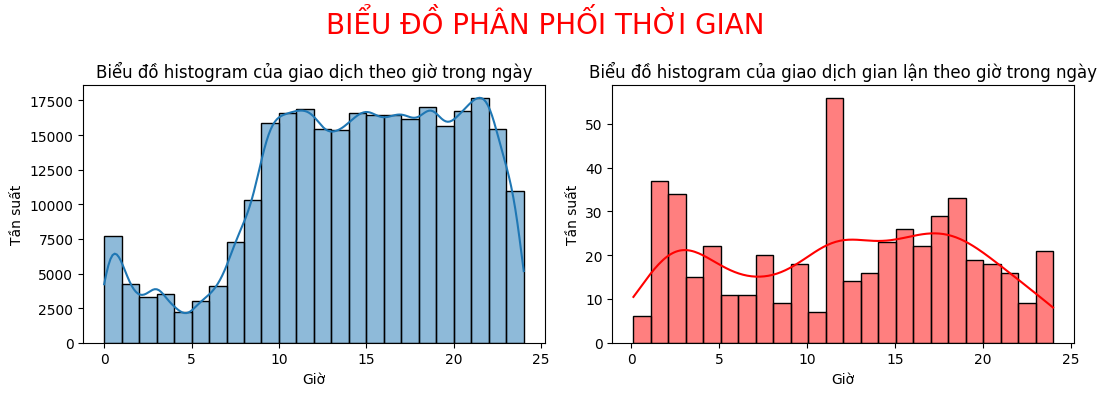

In [20]:
#Phân tích cột Time của bộ dữ liệu
fig3 = plt.figure(figsize = (11,4))

#Chuyển cột time từ giây sang giờ và chia lấy dư cho 24 để lấy theo ngày và gán vào cột Hours
#vì ta cần số lượng giao dịch của từng giờ theo ngày so sánh với số lượng gian lận
df['Hours'] = df['Time'].apply(lambda x: x/3600 % 24)

plt.subplot(1,2,1)
sns.histplot( x = df['Hours'], bins = 24, kde = True)
plt.xlabel('Giờ')
plt.ylabel('Tần suất')
plt.title('Biểu đồ histogram của giao dịch theo giờ trong ngày')

plt.subplot(1,2,2)
fraud_df = df[df['Class'] == 1]
sns.histplot( x = fraud_df['Hours'], bins = 24, kde = True, color = 'red')
plt.xlabel('Giờ')
plt.ylabel('Tần suất')
plt.title('Biểu đồ histogram của giao dịch gian lận theo giờ trong ngày')

fig3.suptitle("BIỂU ĐỒ PHÂN PHỐI THỜI GIAN", fontsize = 20, color = 'r')
plt.tight_layout()
plt.show()

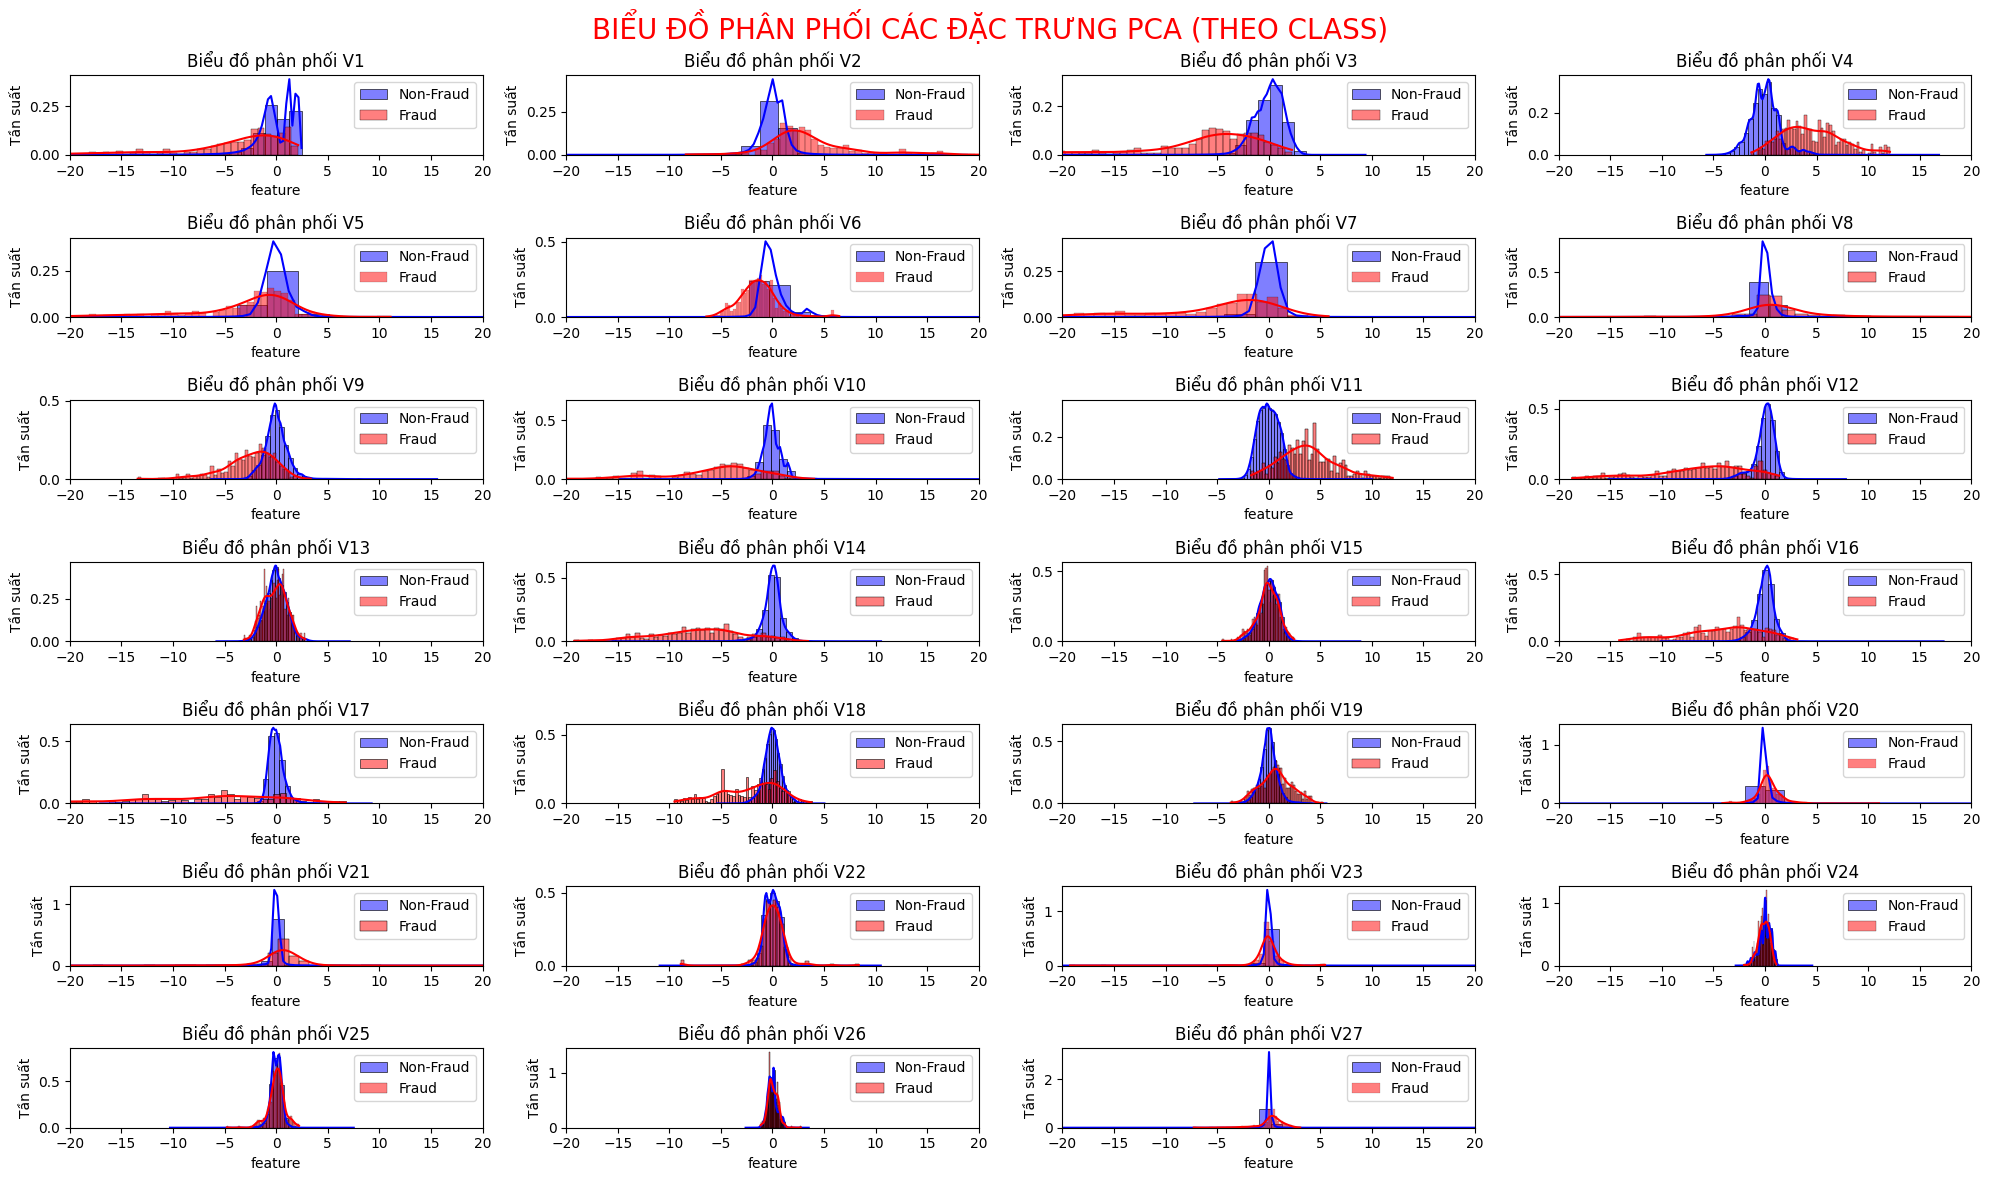

In [21]:
#Biểu đồ phân tích các đặc trưng PCA
fig4 = plt.figure(figsize = (20,12))

for i, feature in enumerate(df.columns[1:28]):
  plt.subplot(7,4, i+1)
  #Áp dụng phân tích theo Class
  sns.histplot( df[df['Class'] == 0][feature], bins = 50, kde = True, color = 'blue', alpha = 0.5, label = 'Non-Fraud', stat = 'density')
  sns.histplot( df[df['Class'] == 1][feature], bins = 50, kde = True, color = 'red' ,alpha = 0.5, label = 'Fraud', stat = 'density')
  plt.xlim(-20,20)
  plt.xlabel('feature')
  plt.ylabel('Tần suất')
  plt.title(f'Biểu đồ phân phối {feature}')
  plt.legend()

fig4.suptitle("BIỂU ĐỒ PHÂN PHỐI CÁC ĐẶC TRƯNG PCA (THEO CLASS) ", fontsize = 20, color = 'r')
plt.tight_layout()


## **3.** TIỀN XỬ LÝ DỮ LIỆU

Thêm các đặc trưng phi tuyến

In [22]:
def add_Is_Night(df):
  df['Is_Night'] = ((df['Hours'] >= 0) & (df['Hours'] <= 5)).astype(int)
  print(df['Is_Night'].value_counts())
  return df

In [23]:
def add_Is_High_Amount(df):
  df['Is_High_Amount'] = (df['Amount'] > 1000).astype(int)
  return df

In [24]:
def analyze_feature(df, col, target = 'Class'):

  df_feature = (df.groupby(col)[target].mean()).reset_index()

  fig = plt.figure(figsize = (10,4))

  #Biểu đồ 1
  plt.subplot(1,2,1)
  sns.countplot(x = col, data = df, hue = target)
  plt.ylabel('Số giao dịch')
  plt.yscale('log')
  plt.title(f'Biểu đồ cột của các giá trị trong cột {col}')

  #Biểu đồ 2
  plt.subplot(1,2,2)
  df_feature.columns = [col, target]

  sns.barplot(data = df_feature, x = col , y = target, hue = col)
  plt.title(f'Biểu đồ cột thể hiện tỉ lệ gian lận của {target} theo {col}')
  plt.ylabel(f'Tỷ lệ gian lận')

  fig.suptitle(f'BIỂU ĐỒ PHÂN PHỐI {col}', fontsize = 20, color = 'r')
  plt.tight_layout()
  plt.show()
  return

Is_Night
0    263862
1     20945
Name: count, dtype: int64


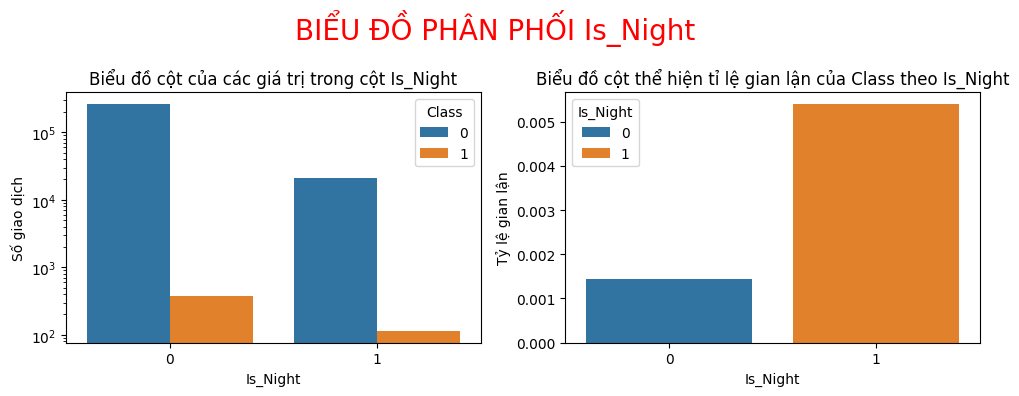

In [25]:
df = add_Is_Night(df)
analyze_feature(df, 'Is_Night')

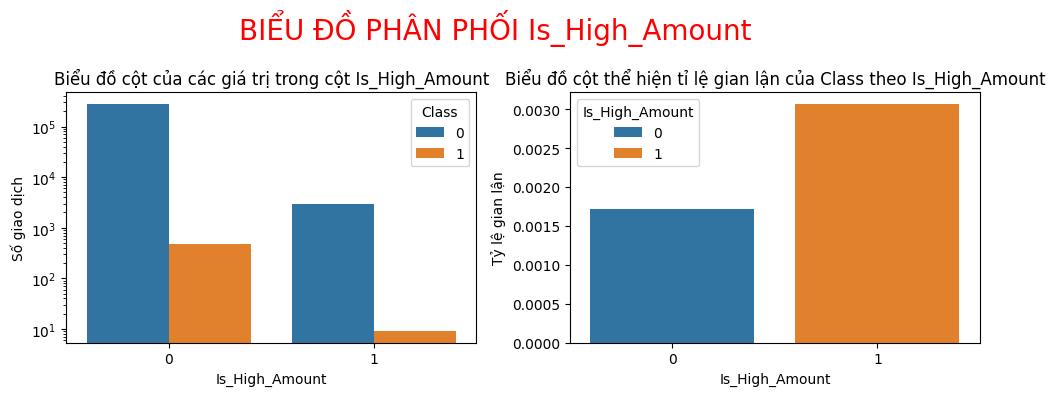

In [26]:
df = add_Is_High_Amount(df)
analyze_feature(df, 'Is_High_Amount')

## **4.** XỬ LÝ DỮ LIỆU






In [27]:
#Tách biến đặc trưng và biến mục tiêu
X = df.drop(columns = ['Class','Time'])
y = df['Class']

**Chia tập huấn luyện**
+ Ở bước này, chia dữ liệu thành 2 phần: 80% để huấn luyện mô hình (Training Set) và 20% để kiểm tra đánh giá (Test Set).

+ stratify=y đảm bảo rằng nếu tập gốc có 0.17% gian lận, thì cả tập Train và tập Test đều giữ nguyên tỷ lệ 0.17% đó.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

df_train_test = pd.DataFrame({
                              'Dữ liệu' : ['Train', 'Test'],
                              'Số lượng mẫu X': [X_train.shape[0], X_test.shape[0]],
                              'Số lượng mẫu y' : [y_train.shape[0], y_test.shape[0]],
                              'Tỷ lệ gian lận': [f'{y_train.mean()*100:.4f}%', f'{y_test.mean()*100:.4f}%']
                              })
df_train_test.set_index('Dữ liệu', inplace = True)
df_train_test.transpose().round(4)

Dữ liệu,Train,Test
Số lượng mẫu X,227845,56962
Số lượng mẫu y,227845,56962
Tỷ lệ gian lận,0.1729%,0.1720%


**Dữ liệu mất cân bằng, các phương pháp được thực hiện:**
  - Random Under-Sampling là phương pháp giảm số lượng mẫu của lớp đa số ( chính là lớp giao dịch bình thường) bằng cách xóa ngẫu nhiên các điểm này.
  - SMOTE (Synthetic Minority Over-sampling Technique) là phương pháp tăng số lượng mẫu lớp thiểu số ( chính là lớp giao dịch gian lận) bằng cách tạo mẫu giả.
  - SMOTE + RUS là SMOTE để tăng thiểu số và RUS để tăng đa số theo tỉ lệ khác nhau.
  - SMOTETomek là SMOTE để tăng thiểu số và Tomek sẽ xóa các điểm đa số ở các vùng biên gần nhau.



In [29]:
def imbalanced_data_processing(X_train, y_train):
  results = {'original' : (X_train, y_train)}

  #Random Under-Samping
  rus = RandomUnderSampler(sampling_strategy = 0.5, random_state = 42)
  X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
  results['under_sampling'] = (X_train_rus, y_train_rus)

  #SMOTE
  smote = SMOTE(sampling_strategy= 0.2, random_state = 42)
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
  results['smote'] = (X_train_smote, y_train_smote)

  #SMOTE + RUS
  pipeline = Pipeline(steps = [('o', smote),('u',rus)])
  X_train_rus_smote, y_train_rus_smote = pipeline.fit_resample(X_train, y_train)
  results['rus_smote'] = (X_train_rus_smote, y_train_rus_smote)

  #SMOTETomek
  smt = SMOTETomek(sampling_strategy= 0.2, random_state = 42 )
  X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
  results['smt'] = (X_train_smt, y_train_smt)

  return results

In [30]:
resample_data = imbalanced_data_processing(X_train, y_train)

In [32]:
save_path_resample_data = '/content/drive/MyDrive/[Khoa]-Phát hiện gian lận thẻ tín dụng /resample_data_23_12_2025.pkl'
joblib.dump(resample_data, save_path_resample_data)
#resample_data = joblib.load(save_path_resample_data)

['/content/drive/MyDrive/[Khoa]-Phát hiện gian lận thẻ tín dụng /resample_data_23_12_2025.pkl']

## **5.** HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH


**Các chỉ số cần lưu ý để đánh giá mô hình**

*   Accuracy: Tỷ lệ phần trăm số lần mô hình đoán đúng trên tổng số mẫu.
*   Confusion matrix: tóm tắt hiệu suất của một mô hình RANDOM FOREST
*   ROC Curve( Đường Cong):
    + Trục X: FPR ( Tỷ lệ làm phiền khách hàng tốt)
    + Trục Y: TPR ( Khả năng bắt trúng kẻ gian)
*   AUC: thể hiện "Độ thông minh" của mô hình khi xếp hạng rủi ro
*   PR-AUC( Diện tích dưới đường cong Precision-Recall):
    + Trục X: Recall ( Trong số các giao dịch mà mô hình báo là gian lận, có bao nhiêu phần trăm là gian lận thật?)
    + Trục Y: Precision ( Mô hình tìm ra được bao nhiêu phần trăm trong tổng số giao dịch gian lận thực tế?)





In [33]:
def calculate_model_metric(model, X_test, y_test, m_name):

  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:,1]

  #Tính toán các chỉ số
  cm = confusion_matrix(y_test, y_pred)
  pr_auc = average_precision_score(y_test, y_prob)
  roc_auc = roc_auc_score(y_test, y_prob)
  f1 = f1_score(y_test, y_pred)

  return {
          'model': model,
          'y_pred': y_pred,
          'y_prob': y_prob,
          'f1_scores': f1,
          'roc_auc': roc_auc,
          'pr_auc': pr_auc,
          'cm': cm
          }

In [34]:
def train_multi_models(resample_data, X_test, y_test):

  models_selection =  {
                      'Logistic': Pipeline([("scaler",StandardScaler()),
                                            ("logistic", LogisticRegression(random_state = 42, max_iter = 1000))]),
                      'RandomForest': RandomForestClassifier(n_estimators = 50, random_state = 42, max_depth = 15,
                                      oob_score = True, n_jobs = -1),
                      'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
                      }

  results = {}

  for method, (X_train_resample, y_train_resample) in resample_data.items():
    print(f">>>> ĐANG TRAIN DATA-SET VỚI PHƯƠNG THỨC {method.upper()} <<<<")
    print("-"*50)
    for model_name, model in models_selection.items():
      print(f"\n>>>> MODEL ĐANG SỬ DỤNG: {model_name.upper()} <<<<")

      if model_name not in results:
        results[model_name] = {}

      if method == 'original':
        if model_name == 'XGBoost':
          scale_ratio = (y_train_resample == 0).sum() / (y_train_resample == 1).sum()
          model.set_params(scale_pos_weight = scale_ratio)
        elif model_name == 'Logistic':
          model.set_params(logistic__class_weight = 'balanced')
        else:
          model.set_params(class_weight = 'balanced')
      else:
        if model_name == 'XGBoost':
          model.set_params(scale_pos_weight = 1)
        elif model_name == 'Logistic':
          model.set_params(logistic__class_weight = None)
        else:
          model.set_params(class_weight = None)

      model.fit(X_train_resample,y_train_resample)
      results[model_name][method] = calculate_model_metric(model, X_test, y_test, method)
      print(f"\n --ĐÃ TRAIN XONG {model_name.upper()}--")
    print("-"*150)

  return results

In [ ]:
final_results = train_multi_models(resample_data, X_test, y_test)

In [35]:
save_path_final_results = '/content/drive/MyDrive/[Khoa]-Phát hiện gian lận thẻ tín dụng /final_results_23_12_2025.pkl'
#joblib.dump(final_results, save_path_final_results)
final_results = joblib.load(save_path_final_results)

In [36]:
def visualize_best_models(final_results, y_test):
  print(">>>> TỔNG HỢP KẾT QUẢ TỐT NHẤT CHO TỪNG LOẠI MODEL <<<<")

  best_models = {}
  for model_name, model_method in final_results.items():
    best_models[model_name] = {}
    summary_df = []
    for method, metrics in model_method.items():
      summary_df.append({
                          'Method': method,
                          'PR-AUC': metrics['pr_auc'],
                          'F1_Score': metrics['f1_scores'],
                          'ROC_AUC': metrics['roc_auc']
                        })

    df_summary = pd.DataFrame(summary_df)
    df_summary.sort_values(by = ['PR-AUC','F1_Score'], ascending = False, inplace = True)
    best_method = df_summary.iloc[0]['Method']
    best_models[model_name][best_method] = model_method[best_method]

    print(f"\n🏆 MODEL: {model_name.upper()}")
    print(f"   -> Method tối ưu nhất: {best_method}")
    print(f"   -> PR-AUC:  {best_models[model_name][best_method]['pr_auc']:.4f}")
    print(f"   -> F1-Score: {best_models[model_name][best_method]['f1_scores']:.4f}")
    print("-" * 30)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"HIỆU SUẤT: {model_name.upper()} ({best_method.upper()})", fontsize=16, color='r', fontweight='bold')

    cm = best_models[model_name][best_method]['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    y_prob = best_models[model_name][best_method]['y_prob']
    RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[1], color='b', name=f'ROC (AUC={best_models[model_name][best_method]["roc_auc"]:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Chance')
    axes[1].set_title('ROC Curve')
    axes[1].grid(True, alpha=0.3)

    PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=axes[2], color='b', name=f'PR (AP={best_models[model_name][best_method]["pr_auc"]:.3f})')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='lower left')

    plt.tight_layout()
    plt.show()
  return best_models

>>>> TỔNG HỢP KẾT QUẢ TỐT NHẤT CHO TỪNG LOẠI MODEL <<<<

🏆 MODEL: LOGISTIC
   -> Method tối ưu nhất: rus_smote
   -> PR-AUC:  0.7254
   -> F1-Score: 0.2639
------------------------------


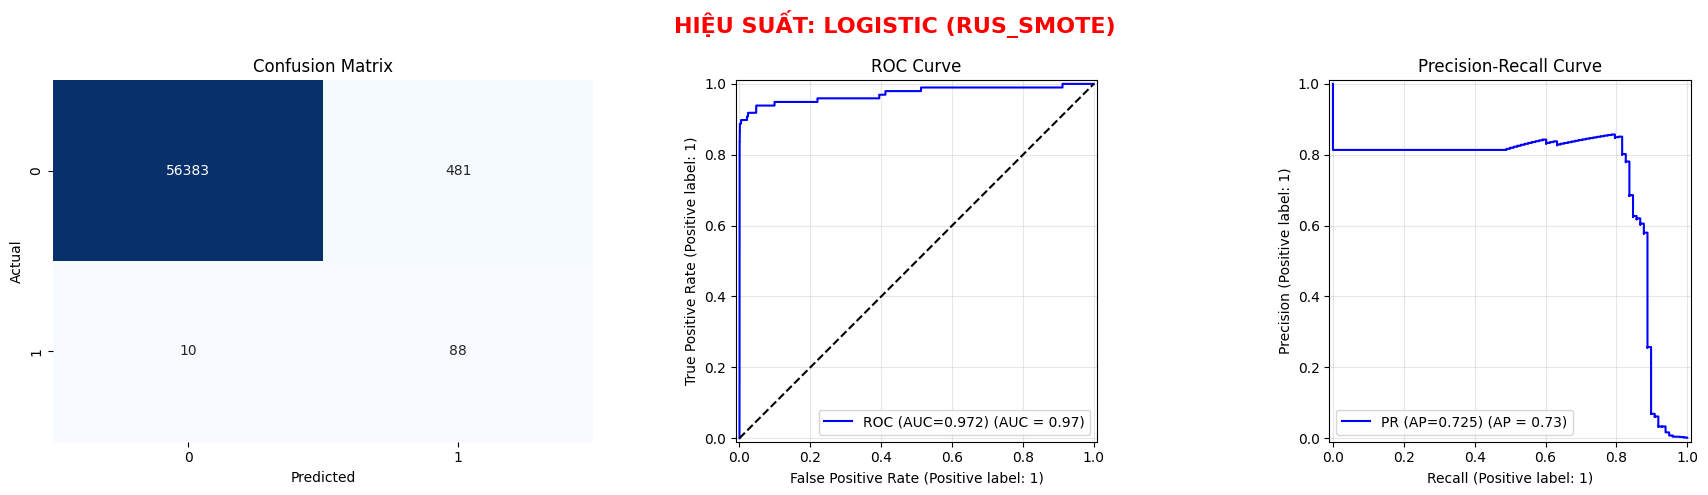


🏆 MODEL: RANDOMFOREST
   -> Method tối ưu nhất: smt
   -> PR-AUC:  0.8832
   -> F1-Score: 0.8390
------------------------------


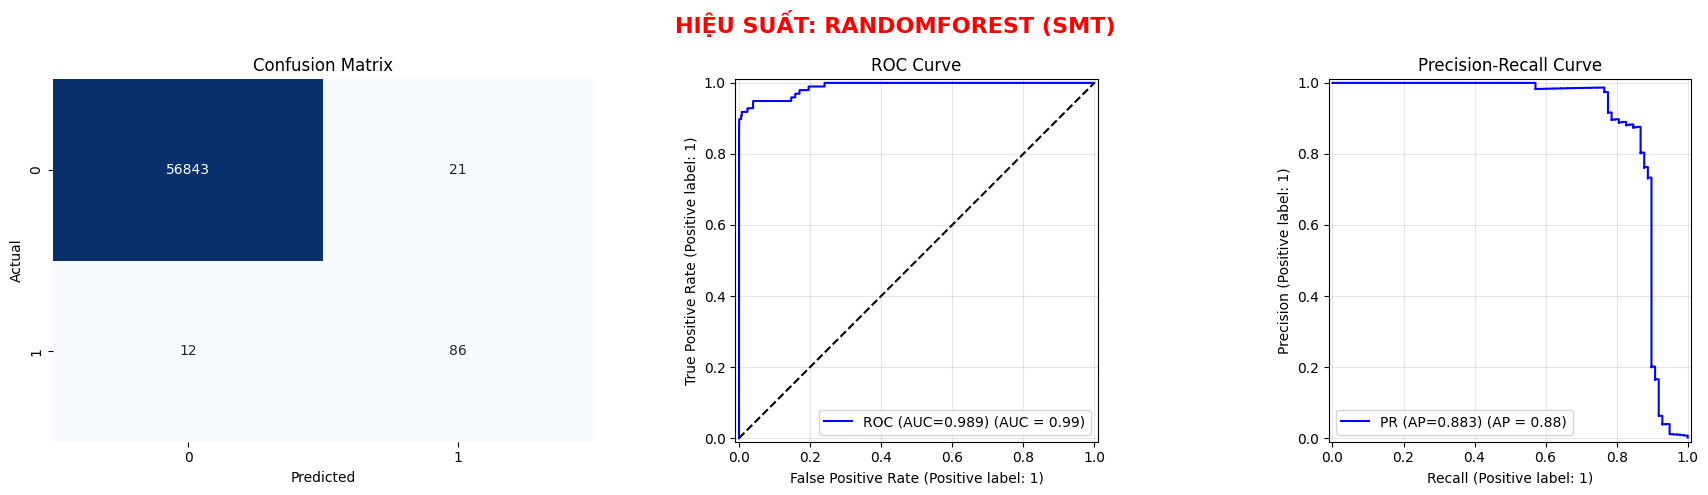


🏆 MODEL: XGBOOST
   -> Method tối ưu nhất: smt
   -> PR-AUC:  0.8774
   -> F1-Score: 0.8442
------------------------------


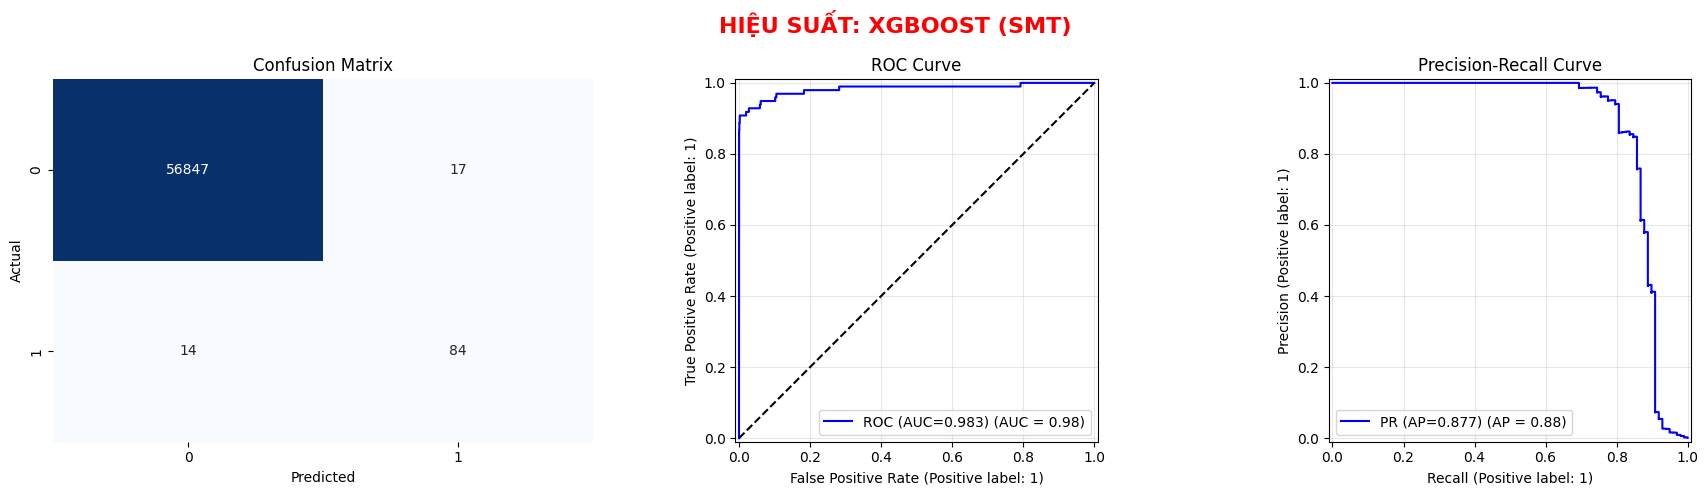

In [37]:
best_models = visualize_best_models(final_results, y_test)

## **6.** TỐI ƯU HÓA MÔ HÌNH SỬ DỤNG GridSearchCV




In [45]:
def optimize_models(best_models, resample_data):
  print(">>>> TỐI ƯU HÓA THAM SỐ CHO TỪNG MODEL <<<<\n")

  models = {}

  for model_name, model_method in best_models.items():

    #lấy tên method
    best_method_name = list(model_method.keys())[0]

    print(f"Đang tinh chỉnh tham số của phương thức {best_method_name} cho {model_name}....\n")

    #Lấy dữ liệu train tương ứng
    X_train_re, y_train_re = resample_data[best_method_name]

    model = None
    param_grid = {}
    cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

    # ==== LOGISTIC MODEL =====
    if model_name == 'Logistic':
      cw = 'balanced' if best_method_name == 'original' else None
      model = Pipeline([
                ('scaler', StandardScaler()),
                ('logistic', LogisticRegression(random_state=42, max_iter=2000, solver='liblinear', class_weight=cw))
              ])
      param_grid = {
                    'logistic__C': [0.01, 0.1, 1, 10],
                    'logistic__penalty': ['l1','l2']
                    }

    # ==== RANDOM FOREST ====
    elif model_name == 'RandomForest':
      cw = 'balanced' if best_method_name == 'original' else None
      model = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight = cw)
      param_grid = {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 15],
                    'min_samples_split': [2, 5]
                    }

    # ==== XGBOOST ====
    elif model_name == 'XGBoost':
      if best_method_name == 'original':
        ratio = float(np.sum(y_train_re == 0)) / np.sum(y_train_re == 1)
        scale_pos = ratio
      else:
        scale_pos = 1
      model = XGBClassifier(eval_metric = 'logloss', random_state = 42, n_jobs = -1, scale_pos_weight = scale_pos)
      param_grid = {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 6]
                    }

    grid = GridSearchCV(estimator = model, param_grid = param_grid,
                        scoring='average_precision', cv = cv, verbose=0, n_jobs=-1)
    grid.fit(X_train_re, y_train_re)

    best_score = grid.best_score_
    print(f"   -> Đã xong! Best PR-AUC (CV): {best_score:.4f}")
    print(f"   -> Params: {grid.best_params_}\n")

    models[model_name] = grid.best_estimator_
  return models

In [ ]:
final_models = optimize_models(best_models, resample_data)

## **7.** TÌM NGƯỠNG TỐI ƯU





In [38]:
save_path_final_models = '/content/drive/MyDrive/[Khoa]-Phát hiện gian lận thẻ tín dụng /final_models_23_12_2025.pkl'

#joblib.dump(final_models, save_path_final_models)
final_models = joblib.load(save_path_final_models)


In [43]:
def find_optimal_threshold_models(final_models, X_test, y_test):
  print(">>>> TÌM NGƯỠNG THRESHOLD TỐI ƯU <<<<\n")
  optimal_thresholds = {}
  for model_name, final_model in final_models.items():

    optimal_thresholds[model_name] = {}

    print(f"->Tìm ngưỡng tối ưu cho mô hình {model_name}<-\n")

    y_probs = final_model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    precision = precision[:-1]
    recall = recall[:-1]
    f1_scores =  2 * (precision * recall) / (precision + recall)

    r_indx = recall > 0.87

    best_f1_scores = f1_scores[r_indx]
    best_precision = precision[r_indx]
    best_recall = recall[r_indx]
    best_thresholds = thresholds[r_indx]

    #Tìm ngưỡng có f1 score cao nhất
    best_idx = np.argmax(best_f1_scores)

    optimal_threshold = best_thresholds[best_idx]
    optimal_f1_score = best_f1_scores[best_idx]
    optimal_precision = best_precision[best_idx]
    optimal_recall = best_recall[best_idx]

    print(f"Ngưỡng tối ưu (Threshold): {optimal_threshold:.4f}")
    print(f" -> Precision: {optimal_precision:.4f}")
    print(f" -> Recall:    {optimal_recall:.4f}")
    print(f" -> F1-Score:  {optimal_f1_score:.4f}")
    print("-"*50)
    optimal_thresholds[model_name] = optimal_threshold

  return optimal_thresholds

In [44]:
final_thresholds = find_optimal_threshold_models(final_models, X_test, y_test)

>>>> TÌM NGƯỠNG THRESHOLD TỐI ƯU <<<<

->Tìm ngưỡng tối ưu cho mô hình Logistic<-

Ngưỡng tối ưu (Threshold): 0.9613
 -> Precision: 0.6014
 -> Recall:    0.8776
 -> F1-Score:  0.7137
--------------------------------------------------
->Tìm ngưỡng tối ưu cho mô hình RandomForest<-

Ngưỡng tối ưu (Threshold): 0.4268
 -> Precision: 0.7768
 -> Recall:    0.8878
 -> F1-Score:  0.8286
--------------------------------------------------
->Tìm ngưỡng tối ưu cho mô hình XGBoost<-

Ngưỡng tối ưu (Threshold): 0.2344
 -> Precision: 0.7016
 -> Recall:    0.8878
 -> F1-Score:  0.7838
--------------------------------------------------




## **8.** CHẠY ÁP DỤNG SO SÁNH NGƯỠNG TỐI ƯU MỚI.

In [46]:
def final_evaluation(final_models, X_test, y_test, final_thresholds):

  for model_name, model in final_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred_new = (y_prob > final_thresholds[model_name]).astype(int)

    y_pred = model.predict(X_test)

    #print(f"==== Ngưỡng áp dụng:{final_thresholds[model_name]:.4f} ==== \n")

    fig,ax = plt.subplots(1,2, figsize = (14,5))

    cm_def = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_def, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
    ax[0].set_title('Ngưỡng Mặc định (0.5)')
    ax[0].set_xlabel('Dự đoán')
    ax[0].set_ylabel('Thực tế')

    cm_new = confusion_matrix(y_test, y_pred_new)
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds', ax=ax[1], cbar=False)
    ax[1].set_title(f'Ngưỡng Tối ưu ({final_thresholds[model_name]:.2f})')
    ax[1].set_xlabel('Dự đoán')
    ax[1].set_ylabel('Thực tế')

    plt.suptitle(f"SO SÁNH HIỆU QUẢ: {model_name.upper()}", fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
    print("-"*50)
  return

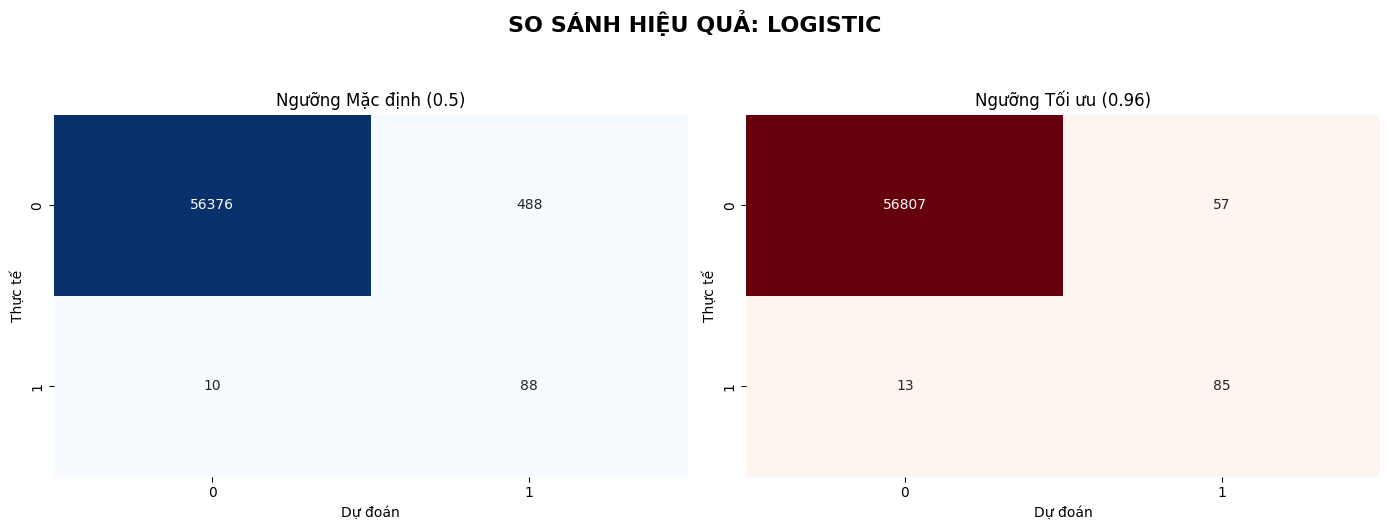

--------------------------------------------------


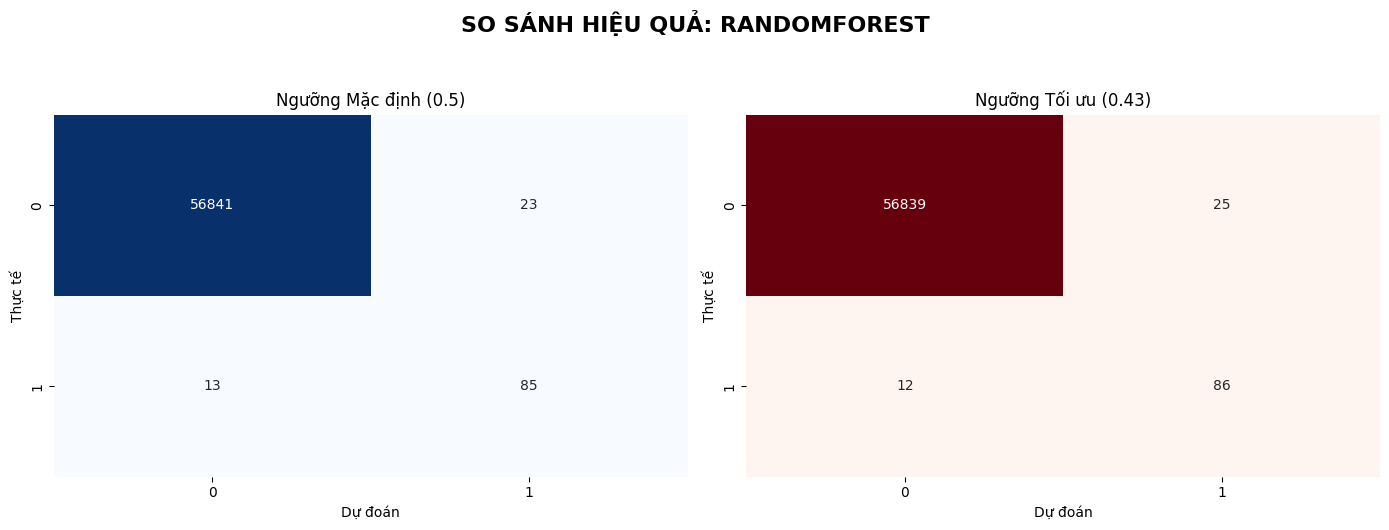

--------------------------------------------------


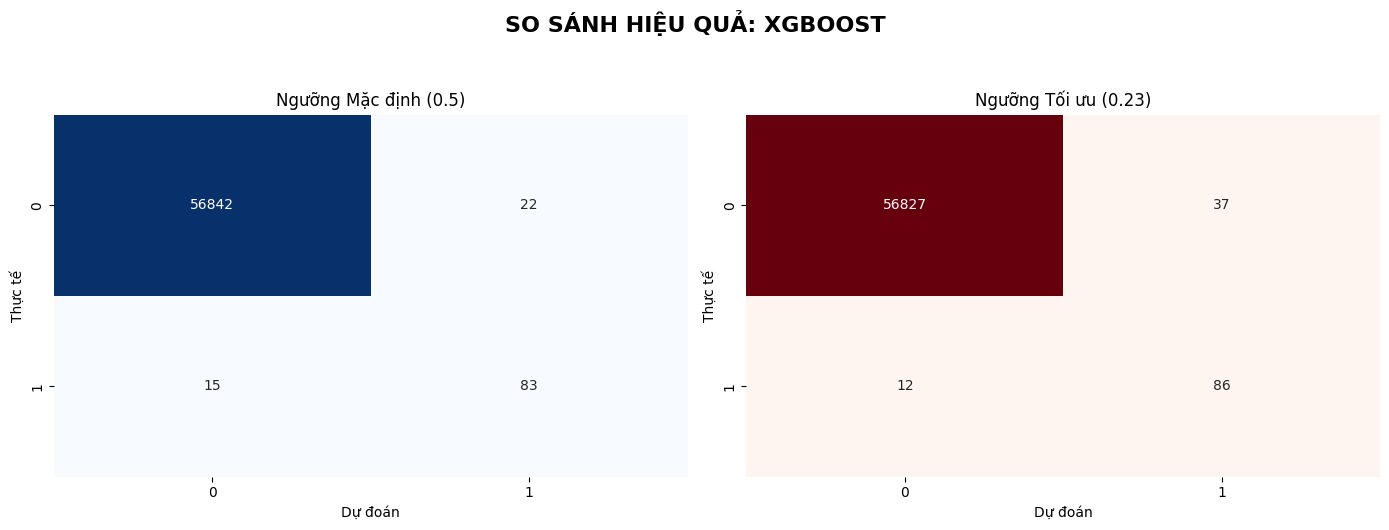

--------------------------------------------------


In [47]:
final_evaluation(final_models, X_test, y_test, final_thresholds)

# **KẾT LUẬN**